In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# K-Means

K-means is a clustering algorithm that partitions data into $K$ clusters. Intuitively, clusters should be chosen so that points in the same cluster are closer to each other vs points in other clusters. 

### Setup

Data: $\{x_1, ..., x_N\}, x_i \in R^D$  
Cluster prototypes: $\{\mu_1, ..., \mu_K\}, \mu_i \in R^D$  
Cluster assigments: $r_{nk}\in \{0,1\}$, equals 1 when $x_n$ is in cluster $k$ 

Cost:  

$$J = \sum_n\sum_k r_{nk}||x_n - \mu_k||^2$$

Our goal is to find $\{\mu_k\}$ and $\{r_{nk}\}$ that minimize $J$.  We can do this with an iterative, two step procedure:

1. Initialize $\mu_k$
2. Until Convergence  
    a. minimize $J$ wrt to $r_{nk}$  
    b. minimize $J$ wrt to $\mu_k$
    
for (a), the $r_{nk}=1$ if cluster k is the closest to point n  
for (b), take the derivative of $J$ wrt $\mu_k$ and set to zero. 

$$J = \sum_n\sum_k r_{nk}||x_n - \mu_k||^2 = \sum_n\sum_k r_{nk}(x_n^Tx_n - 2x_n^T\mu + \mu_k^T\mu_k)$$


$$J' = \sum_n r_{nk}(-2x_n + 2\mu_k) = 0 \rightarrow \mu_k = \frac{\sum_n r_{nk}x_n}{\sum_n r_{nk}}$$

$\mu_k$ is the mean of all the points assigned to cluster $k$.


In [2]:
from sklearn import datasets
np.random.seed(42)


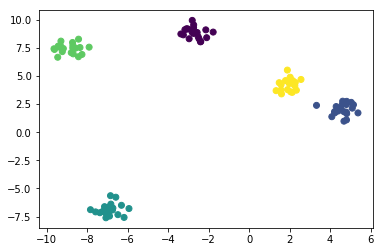

In [3]:
# Generate Data
data, labels= datasets.make_blobs(n_samples=100, random_state=42,
                                  n_features=2, centers = 5, cluster_std = 0.5 )

plt.scatter(data[:,0], data[:,1], c = labels);

In [4]:
# helper functions

def distance(x, y):
    
    return ((x-y)**2).mean()

def find_cluster_assignment(x, cluster_centers):
    
    return np.argmin([distance(x, c) for c in cluster_centers])
    
    

In [5]:
np.random.seed(42)

# Initialize cluster centers
k = 5
D = data.shape[1]
cluster_centers = data[np.random.choice(len(data), size = 5)]


# Iterate Unitl Convergence (just do it for set iterations for ease)
for i in range(30):
    
    # find cluster assignments
    cluster_assignments = np.array([find_cluster_assignment(x, cluster_centers) for x in data])
    
    # compute new means
    cluster_centers = np.array([data[cluster_assignments == i].mean(0) for i in range(k)])
        

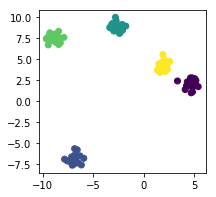

In [6]:
plt.figure(figsize = (3,3))
plt.scatter(data[:,0], data[:,1], c = cluster_assignments);


# K-means for "image segmentation"

In [7]:
import cv2
from sklearn.cluster import KMeans

In [8]:
X = cv2.imread('balloons.jpg', cv2.IMREAD_COLOR)
X = X[:,:,::-1] # openCV does channel order backwards

In [9]:
X_data = X.reshape([-1,3])

In [10]:
k = 7
km = KMeans(n_clusters=k)
labels = km.fit_predict(X_data)

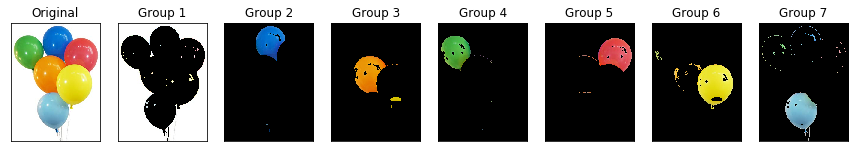

In [11]:
plt.figure(figsize = (15, 8))
plt.subplot(1,k+1,1)
plt.imshow(X)
plt.xticks([])
plt.yticks([])
plt.title('Original')

for i in range(k):
    plt.subplot(1,k+1,i+2)
    plt.imshow(X*(labels.reshape(X.shape[:2])==i)[:,:,None])
    plt.xticks([])
    plt.yticks([])
    plt.title('Group {}'.format(i+1))

# Gaussian Mixture Models

In [12]:
from scipy.stats import norm

In [13]:
# generate data

n = 1000
p = 0.3 #probability of mixture 2

z = np.random.binomial(n = 1, p = p,size = n)

mu1 = 0
sigma1 = 1

mu2 = 5
sigma2 = 1

x1 = np.random.normal(loc = mu1, scale = sigma1, size = n)
x2 = np.random.normal(loc = mu2, scale = sigma2, size = n)

X = np.concatenate([x1[z==0],x2[z==1]])

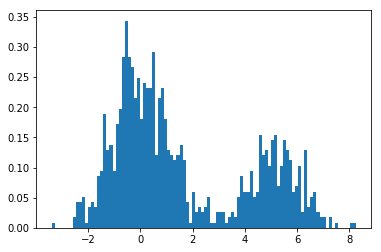

In [14]:
plt.hist(X, bins = 100, ec = None, density = True);

In [15]:
# helper functions

def compute_responsibilities(x, mu, sigma, pi):
    k = len(mu)
    g = [pi[i]* norm.pdf(x, loc = mu[i], scale = sigma[i]) for i in range(k)]
    return g / sum(g)

def mix_pdf(x, m, s, p):

    out = 0

    for mm, ss, pp in zip(m, s, p):

        out+= norm.pdf(x, loc = mm, scale = ss)*pp
        
    return out

In [17]:
_m = np.random.rand(2)*10
_s = np.random.rand(2)*4

_p = np.array([0.5, 0.5])

N = len(X)
for _ in range(20):
    
    # E-step
    responsibility = np.array([compute_responsibilities(xx, _m, _s, _p) for xx in X])
    
    # M-step
    N_k = responsibility.sum(0)
    _m = (responsibility*X[:,None]).sum(0)/N_k
    _s = np.sqrt((((X[:, None]-_m)**2)*responsibility).sum(0)/N_k)
    _p = N_k / N
    

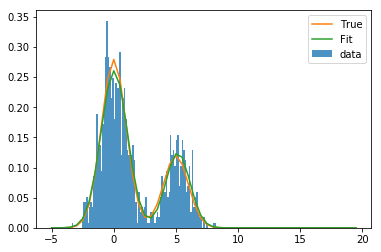

In [18]:
plt.hist(X, bins = 100, ec = None, density = True, label = 'data', alpha = 0.8);

x_range = np.arange(-5, 20, step = 0.5) 
plt.plot(x_range,[mix_pdf(i, [mu1, mu2], [sigma1, sigma2], [1-p, p]) for i in x_range], label = 'True')
plt.plot(x_range,[mix_pdf(i, _m, _s, _p) for i in x_range], label = 'Fit')
plt.legend();